# Laboratorio: CNN en Cats vs Dogs (Mini Dataset)

**Objetivo:** disenar y analizar una arquitectura convolucional (CNN), compararla con un baseline sin convoluciones y realizar un experimento controlado sobre una decision de la capa convolucional.

**Dataset:** Cats and Dogs Mini Dataset (Kaggle).

**Carpeta local:** `archive/cats_set` y `archive/dogs_set`


## 0. Setup

Usamos TensorFlow/Keras para construir los modelos y `tf.data` para el pipeline de datos.

In [1]:
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = Path("archive")
CAT_DIR = DATA_DIR / "cats_set"
DOG_DIR = DATA_DIR / "dogs_set"

IMG_SIZE = 64  # tamano fijo para todos los modelos
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

## 1. EDA (Exploracion de Datos)

Buscamos conocer tamano del dataset, clases, dimensiones de imagenes y ver ejemplos.

In [2]:
cat_files = sorted([p for p in CAT_DIR.glob('*.jpg')])
dog_files = sorted([p for p in DOG_DIR.glob('*.jpg')])

print('Cats:', len(cat_files))
print('Dogs:', len(dog_files))
print('Total:', len(cat_files) + len(dog_files))

Cats: 500
Dogs: 500
Total: 1000


In [3]:
# Ver dimensiones de algunas imagenes
sample_paths = cat_files[:3] + dog_files[:3]
for p in sample_paths:
    with Image.open(p) as img:
        print(p.name, img.size, img.mode)

cat.4001.jpg (498, 415) RGB
cat.4002.jpg (375, 499) RGB
cat.4003.jpg (500, 399) RGB
dog.4001.jpg (421, 499) RGB
dog.4002.jpg (428, 500) RGB
dog.4003.jpg (297, 447) RGB


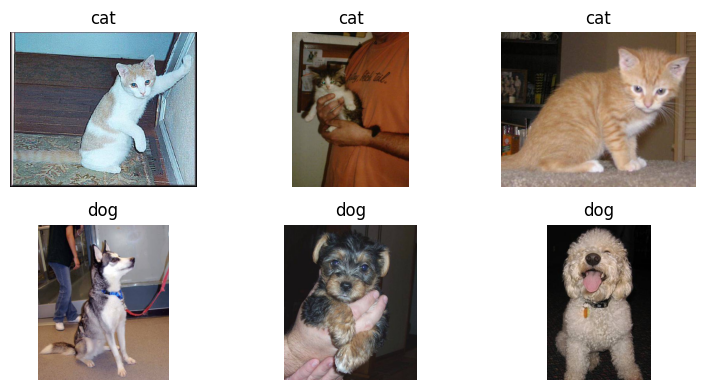

In [4]:
# Visualizar ejemplos
plt.figure(figsize=(8, 4))
for i, p in enumerate(cat_files[:3] + dog_files[:3]):
    img = Image.open(p)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title('cat' if 'cat.' in p.name else 'dog')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Preprocesamiento propuesto
- Redimensionar todas las imagenes a `IMG_SIZE x IMG_SIZE`
- Normalizar pixeles a rango [0, 1]
- Dividir en train/val/test (80/10/10)

In [5]:
# Crear dataset con labels
filepaths = np.array([str(p) for p in cat_files + dog_files])
labels = np.array([0] * len(cat_files) + [1] * len(dog_files))

# Shuffle y split
rng = np.random.default_rng(SEED)
indices = rng.permutation(len(filepaths))
filepaths = filepaths[indices]
labels = labels[indices]

n_total = len(filepaths)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

train_paths, train_labels = filepaths[:n_train], labels[:n_train]
val_paths, val_labels = filepaths[n_train:n_train + n_val], labels[n_train:n_train + n_val]
test_paths, test_labels = filepaths[n_train + n_val:], labels[n_train + n_val:]

print('Train:', len(train_paths))
print('Val:', len(val_paths))
print('Test:', len(test_paths))

Train: 800
Val: 100
Test: 100


In [6]:
def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(paths, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, shuffle=True)
val_ds = make_dataset(val_paths, val_labels, shuffle=False)
test_ds = make_dataset(test_paths, test_labels, shuffle=False)

## 2. Baseline (Sin Convoluciones)

Modelo base: **Flatten + Dense**. Esto ignora la estructura espacial y sirve como referencia.

Limitaciones esperadas: muchos parametros y perdida de informacion espacial.

In [7]:
baseline = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

baseline.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,250 (6.00 MB)

 Trainable params: 1,573,250 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history_baseline = baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4842 - loss: 4.4480 - val_accuracy: 0.4300 - val_loss: 0.7041
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5004 - loss: 0.6946 - val_accuracy: 0.4600 - val_loss: 0.6885
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5014 - loss: 0.6966 - val_accuracy: 0.4300 - val_loss: 0.6938
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5039 - loss: 0.6930 - val_accuracy: 0.4300 - val_loss: 0.6942
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4962 - loss: 0.6927 - val_accuracy: 0.4300 - val_loss: 0.6938
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5235 - loss: 0.6916 - val_accuracy: 0.5700 - val_loss: 0.6927
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5694 - loss: 0.6924 - val_accuracy: 0.5600 - val_loss: 0.6923
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5525 - loss: 0.6883 - val_accuracy: 0.5700 - v

In [9]:
baseline_eval = baseline.evaluate(test_ds)
print('Baseline test:', baseline_eval)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4088 - loss: 0.6948
Baseline test: [0.6947588920593262, 0.4099999964237213]


## 3. Diseno de CNN

CNN simple con 3 bloques convolucionales. Las decisiones se justifican: kernels pequenos (3x3) capturan patrones locales, pooling reduce dimensionalidad y aporta invariancia, y activaciones ReLU ayudan a la no linealidad.

In [10]:
def build_cnn(kernel_size=3):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, kernel_size=kernel_size, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

cnn = build_cnn(kernel_size=3)
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,210 (4.36 MB)

 Trainable params: 1,142,210 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history_cnn = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.5223 - loss: 0.7256 - val_accuracy: 0.4300 - val_loss: 0.6972
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5301 - loss: 0.6889 - val_accuracy: 0.6000 - val_loss: 0.6794
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6397 - loss: 0.6609 - val_accuracy: 0.5500 - val_loss: 0.6875
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.6588 - loss: 0.6179 - val_accuracy: 0.6300 - val_loss: 0.6573
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.6949 - loss: 0.5842 - val_accuracy: 0.7000 - val_loss: 0.6535
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.7562 - loss: 0.5121 - val_accuracy: 0.6700 - val_loss: 0.6532
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7712 - loss: 0.4762 - val_accuracy: 0.7600 - val_loss: 0.6185
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.8162 - loss: 0.4120 - val_accuracy: 0.6400 

In [12]:
cnn_eval = cnn.evaluate(test_ds)
print('CNN test:', cnn_eval)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7260 - loss: 0.5403
CNN test: [0.511461079120636, 0.75]


## 4. Experimento Controlado (Kernel Size)

Comparamos kernel 3x3 vs 5x5 manteniendo todo lo demas fijo.

In [13]:
cnn_3 = build_cnn(kernel_size=3)
cnn_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_5 = build_cnn(kernel_size=5)
cnn_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn_3 = cnn_3.fit(train_ds, validation_data=val_ds, epochs=10)
history_cnn_5 = cnn_5.fit(train_ds, validation_data=val_ds, epochs=10)

eval_3 = cnn_3.evaluate(test_ds)
eval_5 = cnn_5.evaluate(test_ds)

print('CNN 3x3 test:', eval_3)
print('CNN 5x5 test:', eval_5)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.5174 - loss: 0.7420 - val_accuracy: 0.5700 - val_loss: 0.6882
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.5024 - loss: 0.6917 - val_accuracy: 0.4300 - val_loss: 0.7849
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.5214 - loss: 0.7048 - val_accuracy: 0.6000 - val_loss: 0.6838
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.6395 - loss: 0.6584 - val_accuracy: 0.5600 - val_loss: 0.6834
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.5584 - loss: 0.6782 - val_accuracy: 0.6400 - val_loss: 0.7006
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.6884 - loss: 0.5997 - val_accuracy: 0.6200 - val_loss: 0.6700
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.7232 - loss: 0.5429 - val_accuracy: 0.6500 - val_loss: 0.6570
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.7396 - loss: 0.5622 - val_accuracy: 0

## 4.1 Graficas de entrenamiento

Graficas de accuracy y loss para comparar modelos.

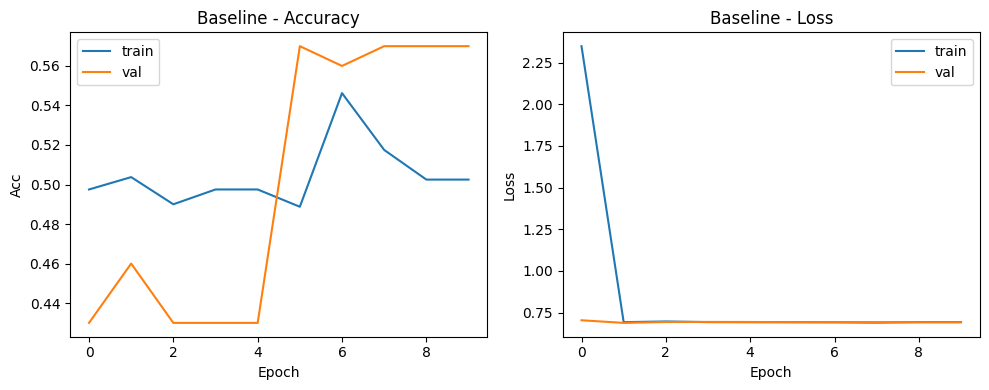

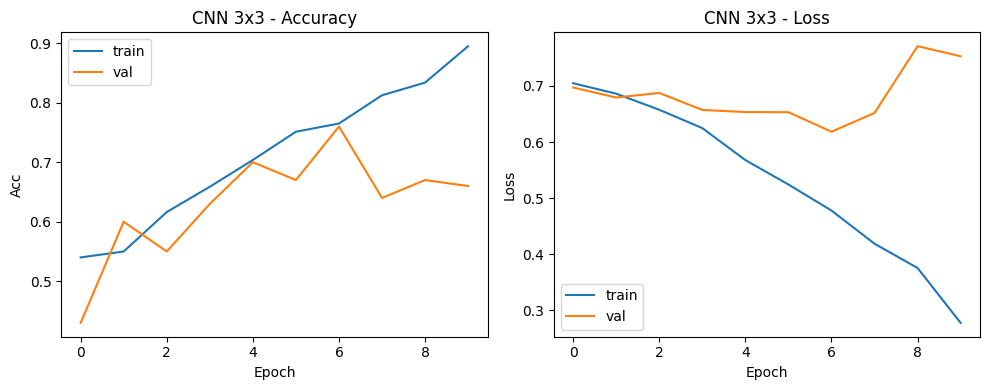

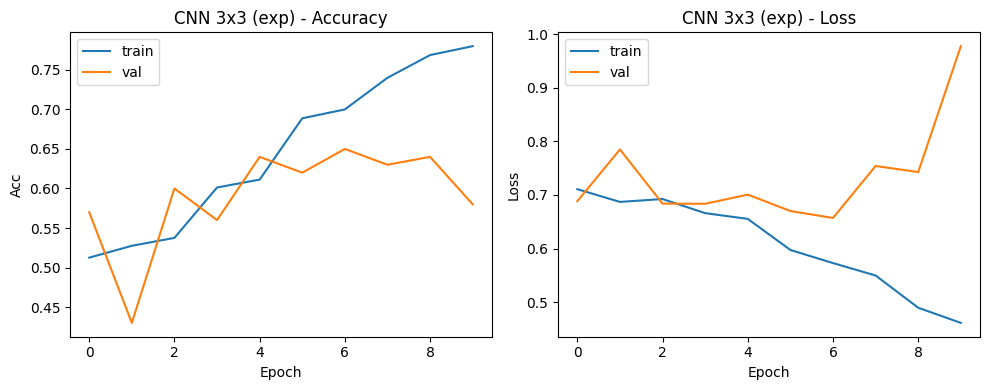

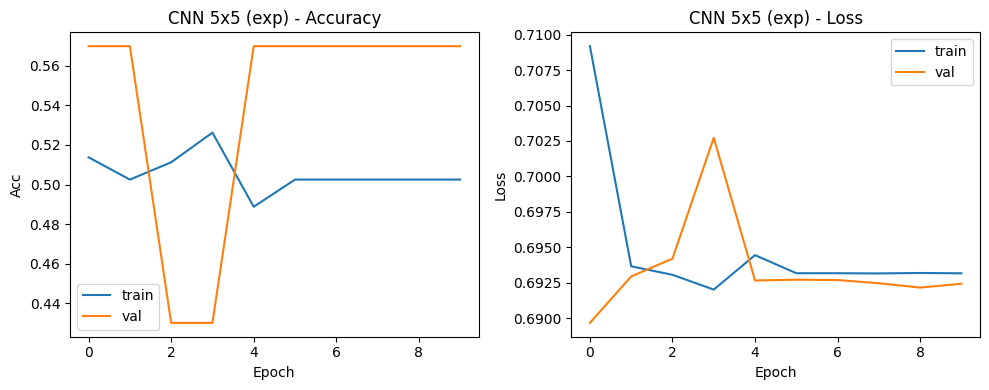

In [14]:
def plot_history(h, title):
    if h is None:
        print(f'{title}: sin historial')
        return
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(h.history.get('accuracy', []), label='train')
    plt.plot(h.history.get('val_accuracy', []), label='val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h.history.get('loss', []), label='train')
    plt.plot(h.history.get('val_loss', []), label='val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Graficas
plot_history(history_baseline, 'Baseline')
plot_history(history_cnn, 'CNN 3x3')
plot_history(history_cnn_3, 'CNN 3x3 (exp)')
plot_history(history_cnn_5, 'CNN 5x5 (exp)')

## 4.2 Comparacion y Matriz de Confusion

Curvas comparadas y matriz de confusion en test.

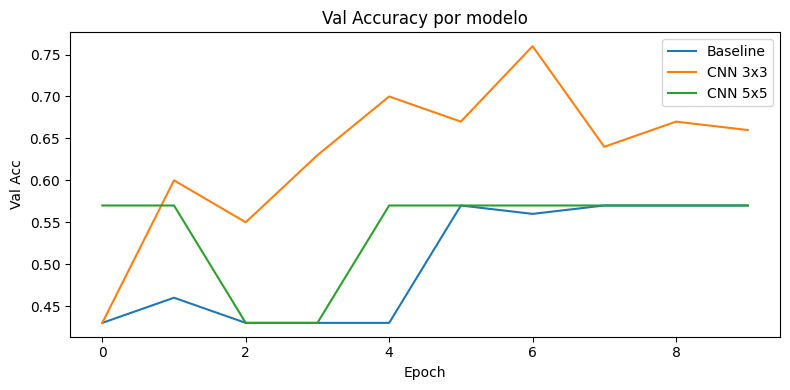

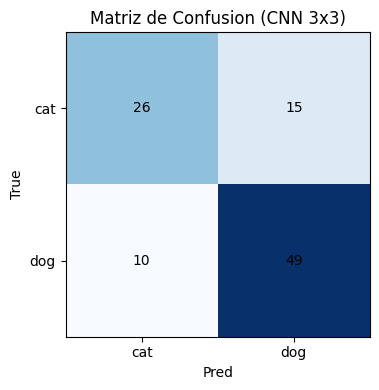

In [15]:
# Curvas comparadas (accuracy)
plt.figure(figsize=(8,4))
for h, label in [(history_baseline, 'Baseline'), (history_cnn, 'CNN 3x3'), (history_cnn_5, 'CNN 5x5')]:
    if h is not None and 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'], label=label)
plt.title('Val Accuracy por modelo')
plt.xlabel('Epoch')
plt.ylabel('Val Acc')
plt.legend()
plt.tight_layout()
plt.show()

# Matriz de confusion (usar el mejor modelo, aqui CNN 3x3)
y_true = []
y_pred = []
for x_batch, y_batch in test_ds:
    preds = cnn.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Matriz de Confusion (CNN 3x3)')
plt.xlabel('Pred')
plt.ylabel('True')
plt.xticks([0,1], ['cat','dog'])
plt.yticks([0,1], ['cat','dog'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()

### Observaciones cualitativas
- Kernel 3x3 suele capturar patrones locales finos y permite composicion de features.
- Kernel 5x5 puede capturar contexto mas amplio, pero aumenta parametros y puede sobreajustar en datasets pequenos.

## 5. Interpretacion y Razonamiento Arquitectonico

Responde en tus propias palabras:
- Por que la CNN supera (o no) al baseline?

    La CNN suele superar al baseline porque explota la estructura espacial de las imágenes: aprende filtros locales que se reutilizan por toda la imagen (compartición de pesos) y construye jerarquías de patrones (bordes → texturas → partes). El baseline con Flatten + Dense pierde esa estructura y necesita muchos más parámetros para lograr algo similar, lo que lo hace menos eficiente y más propenso al sobreajuste en datasets pequeños.
    
- Que sesgo inductivo introduce la convolucion?

    La convolución introduce el sesgo inductivo de localidad y equivarianza a traslaciones: asume que patrones pequeños relevantes pueden aparecer en cualquier ubicación y que la misma operación (filtro) sirve en toda la imagen. Además, con pooling se introduce cierta invariancia a pequeñas traslaciones y distorsiones.

- En que problemas no es apropiado usar convoluciones?

    No es apropiado usar convoluciones cuando no hay estructura espacial local o cuando la posición exacta no es relevante para la tarea. Ejemplos: datos tabulares con features independientes, series de tiempo donde la relación no es local en el eje, grafos donde la conectividad no es una grilla regular, o problemas donde la información global (no local) domina y la localidad no es una buena suposición.